In [1]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

import gym
from matplotlib import pylab as plt

import daves_rl_lib
from daves_rl_lib import drivers
from daves_rl_lib import networks
from daves_rl_lib.algorithms import advantage_actor_critic
from daves_rl_lib.algorithms import policy_gradient
from daves_rl_lib.environments import gym_environment
from daves_rl_lib.environments import environment_lib
from daves_rl_lib.internal import util

In [2]:
def run_experiment(env, agent, seed=jax.random.PRNGKey(0)):
    seed, weights_init_seed, state_init_seed = jax.random.split(seed, 3)

    state = env.reset(seed=state_init_seed)
    initial_state_observation = state.observation

    weights = agent.init_weights(seed=weights_init_seed,
                                dummy_observation=state.observation,
                                dummy_action=env.action_space.dummy_action())
    select_action = jax.jit(
        lambda w, obs, s: agent.action_dist(w, obs).sample(seed=s))
    update = jax.jit(agent.update)

    durations = []
    returns = []

    episode = 0
    def step_episode(state, weights, episode_seed):
        seed, state_init_seed = jax.random.split(episode_seed, 2)
        state = env.reset(seed=state_init_seed)
        num_steps = 0
        while not state.done:
            seed, action_seed, env_seed = jax.random.split(seed, 3)
            action = select_action(weights, state.observation, action_seed)
            next_state = env.step(action)
            weights = update(weights,
                            transition=environment_lib.Transition(
                                observation=state.observation,
                                action=action,
                                next_observation=next_state.observation,
                                reward=next_state.reward,
                                done=next_state.done)
                            )
            state = next_state
            num_steps += 1
        return state, weights, seed, num_steps

    return state, weights, seed, step_episode

## Small-scale experiments

### q1_sb_no_rtg_dsa

In [3]:
env_name = 'CartPole-v0'  # 'MountainCar-v0'
discount_factor = 0.99
learning_rate = 5e-3

env = gym_environment.GymEnvironment(
    gym.make(env_name),
    discount_factor=discount_factor)

agent_q1_sb_no_rtg_dsa = policy_gradient.PolicyGradientAgent(
    policy_net=networks.make_model([64, 64, env.action_space.num_actions],
                                   obs_size=env.observation_size,
                                   activate_final=tfp.distributions.Categorical),
    policy_optimizer=optax.adam(learning_rate),
    steps_per_update=1000,
    discount_factor=discount_factor,
    standardize_advantages=False,
    reward_to_go=False)

seed = jax.random.PRNGKey(0)

state, weights, seed, step_episode_q1_sb_no_rtg_dsa = run_experiment(
        agent=agent_q1_sb_no_rtg_dsa, env=env, seed=seed)

/home/davmre/rl/.venv/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [4]:

durations_q1_sb_no_rtg_dsa = []
episode = 0
while weights.num_updates < 100:
        state, weights, seed, num_steps = step_episode_q1_sb_no_rtg_dsa(state, weights, seed)
        print(f"Finished episode {episode} of length {num_steps} with return {state.episode_return} after {weights.num_updates} updates.")
        episode += 1
        durations_q1_sb_no_rtg_dsa.append(num_steps)



Finished episode 0 of length 16 with return 14.854222890512437 after 0 updates.
Finished episode 1 of length 13 with return 12.247897700103202 after 0 updates.
Finished episode 2 of length 24 with return 21.432185919278098 after 0 updates.
Finished episode 3 of length 16 with return 14.854222890512437 after 0 updates.
Finished episode 4 of length 68 with return 49.51141112129299 after 0 updates.
Finished episode 5 of length 12 with return 11.361512828387072 after 0 updates.
Finished episode 6 of length 11 with return 10.466174574128356 after 0 updates.
Finished episode 7 of length 22 with return 19.836941046095397 after 0 updates.
Finished episode 8 of length 35 with return 29.655230500043043 after 0 updates.
Finished episode 9 of length 25 with return 22.217864060085315 after 0 updates.
Finished episode 10 of length 30 with return 26.029962661171947 after 0 updates.
Finished episode 11 of length 13 with return 12.247897700103202 after 0 updates.
Finished episode 12 of length 10 with r

### q1_sb_rtg_dsa

In [5]:
env_name = 'CartPole-v0'  # 'MountainCar-v0'
discount_factor = 0.99
learning_rate = 5e-3

env = gym_environment.GymEnvironment(
    gym.make(env_name),
    discount_factor=discount_factor)

agent_q1_sb_rtg_dsa = policy_gradient.PolicyGradientAgent(
    policy_net=networks.make_model([64, 64, env.action_space.num_actions],
                                   obs_size=env.observation_size,
                                   activate_final=tfp.distributions.Categorical),
    policy_optimizer=optax.adam(learning_rate),
    steps_per_update=1000,
    discount_factor=discount_factor,
    standardize_advantages=False,
    reward_to_go=True)

seed = jax.random.PRNGKey(0)

state, weights, seed, step_episode_q1_sb_rtg_dsa = run_experiment(
        agent=agent_q1_sb_rtg_dsa, env=env, seed=seed)

/home/davmre/rl/.venv/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [6]:

durations_q1_sb_rtg_dsa = []
episode = 0
while weights.num_updates < 100:
        state, weights, seed, num_steps = step_episode_q1_sb_rtg_dsa(state, weights, seed)
        print(f"Finished episode {episode} of length {num_steps} with return {state.episode_return} after {weights.num_updates} updates.")
        episode += 1
        durations_q1_sb_rtg_dsa.append(num_steps)


Finished episode 0 of length 16 with return 14.854222890512437 after 0 updates.
Finished episode 1 of length 13 with return 12.247897700103202 after 0 updates.
Finished episode 2 of length 24 with return 21.432185919278098 after 0 updates.
Finished episode 3 of length 16 with return 14.854222890512437 after 0 updates.
Finished episode 4 of length 68 with return 49.51141112129299 after 0 updates.
Finished episode 5 of length 12 with return 11.361512828387072 after 0 updates.
Finished episode 6 of length 11 with return 10.466174574128356 after 0 updates.
Finished episode 7 of length 22 with return 19.836941046095397 after 0 updates.
Finished episode 8 of length 35 with return 29.655230500043043 after 0 updates.
Finished episode 9 of length 25 with return 22.217864060085315 after 0 updates.
Finished episode 10 of length 30 with return 26.029962661171947 after 0 updates.
Finished episode 11 of length 13 with return 12.247897700103202 after 0 updates.
Finished episode 12 of length 10 with r

### q1_sb_rtg_na

In [7]:
env_name = 'CartPole-v0'  # 'MountainCar-v0'
discount_factor = 0.99
learning_rate = 5e-3

env = gym_environment.GymEnvironment(
    gym.make(env_name),
    discount_factor=discount_factor)

agent_q1_sb_rtg_na = policy_gradient.PolicyGradientAgent(
    policy_net=networks.make_model([64, 64, env.action_space.num_actions],
                                   obs_size=env.observation_size,
                                   activate_final=tfp.distributions.Categorical),
    policy_optimizer=optax.adam(learning_rate),
    steps_per_update=1000,
    discount_factor=discount_factor,
    standardize_advantages=True,
    reward_to_go=True)

seed = jax.random.PRNGKey(0)

state, weights, seed, step_episode_q1_sb_rtg_na = run_experiment(
        agent=agent_q1_sb_rtg_na, env=env, seed=seed)

/home/davmre/rl/.venv/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [8]:
durations_q1_sb_rtg_na = []
episode = 0
while weights.num_updates < 100:
        state, weights, seed, num_steps = step_episode_q1_sb_rtg_na(state, weights, seed)
        print(f"Finished episode {episode} of length {num_steps} with return {state.episode_return} after {weights.num_updates} updates.")
        episode += 1
        durations_q1_sb_rtg_na.append(num_steps)

Finished episode 0 of length 16 with return 14.854222890512437 after 0 updates.
Finished episode 1 of length 13 with return 12.247897700103202 after 0 updates.
Finished episode 2 of length 24 with return 21.432185919278098 after 0 updates.
Finished episode 3 of length 16 with return 14.854222890512437 after 0 updates.
Finished episode 4 of length 68 with return 49.51141112129299 after 0 updates.
Finished episode 5 of length 12 with return 11.361512828387072 after 0 updates.
Finished episode 6 of length 11 with return 10.466174574128356 after 0 updates.
Finished episode 7 of length 22 with return 19.836941046095397 after 0 updates.
Finished episode 8 of length 35 with return 29.655230500043043 after 0 updates.
Finished episode 9 of length 25 with return 22.217864060085315 after 0 updates.
Finished episode 10 of length 30 with return 26.029962661171947 after 0 updates.
Finished episode 11 of length 13 with return 12.247897700103202 after 0 updates.
Finished episode 12 of length 10 with r

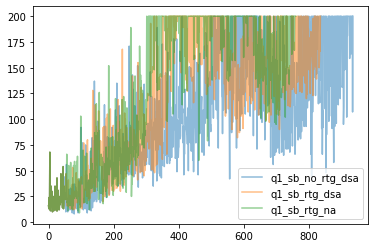

In [11]:
plt.plot(durations_q1_sb_no_rtg_dsa, label='q1_sb_no_rtg_dsa', alpha=0.5)
plt.plot(durations_q1_sb_rtg_dsa, label='q1_sb_rtg_dsa', alpha=0.5)
plt.plot(durations_q1_sb_rtg_na, label='q1_sb_rtg_na', alpha=0.5)
plt.legend()

837

## Inverted pendulum

In [3]:
from daves_rl_lib.algorithms import advantage_actor_critic
from daves_rl_lib.environments import dm_control_environment
from dm_control import suite

In [55]:
discount_factor = 0.99
policy_learning_rate = 5e-2
value_learning_rate = 1e-1
use_critic = True

In [58]:
random_state = np.random.RandomState(42)
dm_env = suite.load('pendulum', 'swingup', task_kwargs={'random': random_state})

env = dm_control_environment.DMControlEnvironment(
    dm_env,
    discount_factor=discount_factor,
    max_episode_length=50,
    action_space=dm_control_environment.action_space_from_dm_control_spec(dm_env.action_spec()))

In [59]:
if use_critic:
    pendulum_agent = advantage_actor_critic.A2CAgent(
        policy_net=networks.make_model([64, 64, 2],
                                    obs_size=env.observation_size,
                                    activate_final=(lambda x: 
                                        networks.from_logits(
                                            dist_cls=tfp.distributions.Normal,
                                            logits=x,
                                            reinterpreted_batch_ndims=1))),
        policy_optimizer=optax.adam(learning_rate),
        value_net=networks.make_model([64, 64, 1],
                                    obs_size=env.observation_size),
        value_optimizer=optax.adam(value_learning_rate),
        steps_per_update=67,
        entropy_regularization=0.01,
        discount_factor=discount_factor)
else:
    pendulum_agent = policy_gradient.PolicyGradientAgent(
        policy_net=networks.make_model([64, 64, 2],
                                    obs_size=env.observation_size,
                                    activate_final=(lambda x: 
                                        networks.from_logits(
                                            dist_cls=tfp.distributions.Normal,
                                            logits=x,
                                            reinterpreted_batch_ndims=1))),
        policy_optimizer=optax.adam(learning_rate),
        steps_per_update=5000,
        discount_factor=discount_factor,
        reward_to_go=True)

In [60]:


seed = jax.random.PRNGKey(0)

state, weights, seed, pendulum_step = run_experiment(
        agent=pendulum_agent, env=env, seed=seed)

In [61]:
durations_pendulum = []
returns_pendulum = []
episode = 0
while weights.num_updates < 1000:
        state, weights, seed, num_steps = pendulum_step(state, weights, seed)
        print(f"Finished episode {episode} of length {num_steps} with return {state.episode_return} after {weights.num_updates} updates.")
        episode += 1
        durations_pendulum.append(num_steps)
        returns_pendulum.append(state.episode_return)

Finished episode 0 of length 50 with return 0.0 after 0 updates.
Finished episode 1 of length 50 with return 0.0 after 1 updates.
Finished episode 2 of length 50 with return 0.0 after 2 updates.
Finished episode 3 of length 50 with return 0.0 after 2 updates.
Finished episode 4 of length 50 with return 0.0 after 3 updates.
Finished episode 5 of length 50 with return 0.0 after 4 updates.
Finished episode 6 of length 50 with return 0.0 after 5 updates.
Finished episode 7 of length 50 with return 0.0 after 5 updates.
Finished episode 8 of length 50 with return 0.0 after 6 updates.
Finished episode 9 of length 50 with return 0.0 after 7 updates.
Finished episode 10 of length 50 with return 0.0 after 8 updates.
Finished episode 11 of length 50 with return 0.0 after 8 updates.
Finished episode 12 of length 50 with return 0.0 after 9 updates.
Finished episode 13 of length 50 with return 0.0 after 10 updates.
Finished episode 14 of length 50 with return 0.0 after 11 updates.
Finished episode 1

KeyboardInterrupt: 

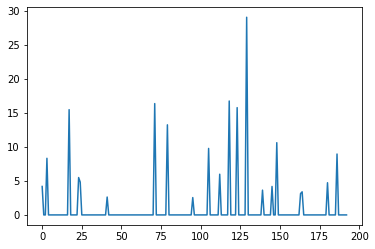

In [37]:
plt.plot(returns_pendulum)